In [1]:
import shutil
import datetime
from dateutil import relativedelta
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from matplotlib import cm
%matplotlib inline

In [2]:
ROOT = Path("./")
DATA = ROOT/'data'
IMAGES = ROOT/'images'
# [f for f in ROOT.iterdir()]
# [f for f in DATA.iterdir()]

print('ROOT =', ROOT)
print('DATA =', DATA)
print('IMAGES =', IMAGES)

ROOT = .
DATA = data
IMAGES = images


In [3]:
%ls {DATA}

 Volume in drive C has no label.
 Volume Serial Number is FCBC-A9FB

 Directory of C:\Users\laura\covid-19\covid-19_analysis_NC\data

01/08/2021  08:20 PM    <DIR>          .
01/08/2021  08:20 PM    <DIR>          ..
01/07/2021  10:10 PM        15,318,162 MECK_COVID_Cases_Restricted_Detailed_12312020.csv
01/25/2021  03:24 PM             8,742 weekly_covid19_report_mecknc.csv
               2 File(s)     15,326,904 bytes
               2 Dir(s)  282,381,209,600 bytes free


### 0. Reading File

In [4]:
df = pd.read_csv(DATA/'MECK_COVID_Cases_Restricted_Detailed_12312020.csv')
pd.set_option('display.max_columns', None)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55801 entries, 0 to 55800
Data columns (total 32 columns):
race_ethnicity_combined    55645 non-null object
current_status             55801 non-null object
cdc_case_earliest_dt       55801 non-null object
cdc_report_dt              55801 non-null object
sex                        55767 non-null object
onset_dt                   22927 non-null object
pos_spec_dt                55784 non-null object
hosp_yn                    55801 non-null object
icu_yn                     55801 non-null object
death_yn                   55801 non-null object
hc_work_yn                 55586 non-null object
pna_yn                     55801 non-null object
abxchest_yn                55801 non-null object
acuterespdistress_yn       55801 non-null object
mechvent_yn                55801 non-null object
fever_yn                   55801 non-null object
sfever_yn                  55801 non-null object
chills_yn                  55801 non-null object
myalgia_y

### Looking at the Data

This is one row of the data to get an idea of what I'm working with.

In [5]:
# df.head(2)

In [6]:
df.death_yn.unique()

array(['No', 'Missing', 'Yes', 'Unknown'], dtype=object)

### Totals Covid Outcomes - All Ages
Deaths and Survivals

In [7]:
## Total Deaths and Survivals
total_d = pd.DataFrame(df['death_yn'].value_counts())
total_d['percentage']= df['death_yn'].value_counts(normalize=True).round(4)*(100)
total_d = total_d.rename(columns={'death_yn': 'count'}, index={'No': 'Surv', 'Yes': 'Deaths'})
## this column will be used to create chart labels next/above bars
total_d['label'] = total_d['count'].astype(str) + "\n(" + total_d['percentage'].astype(str) + "%)"
total_d

,count,percentage,label
Surv,55238,98.99,55238\n(98.99%)
Deaths,544,0.97,544\n(0.97%)
Missing,18,0.03,18\n(0.03%)
Unknown,1,0.00,1\n(0.0%)


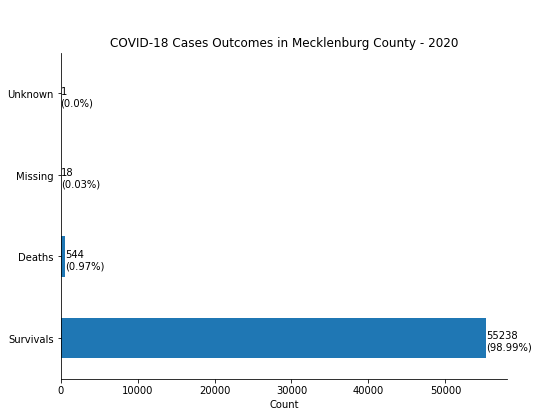

In [8]:
## plotting total_d count values
ax = total_d.plot(y=['count'], kind='barh',
                  legend=False,
                  figsize=(8,6),
                  title='\n\nCOVID-18 Cases Outcomes in Mecklenburg County - 2020')

# text for chart
label_per = [s for s in total_d['label']]
#print(label_per) # like ['55238, 98.99%', '544, 0.97%', '18, 0.03%', '1, 0.0%']

ax.set_yticklabels(['Survivals', 'Deaths', 'Missing', 'Unknown'])
ax.set_xlabel('Count')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## Add labels next to bars - count and percentage ----- https://stackoverflow.com/questions/61718127/add-percent-and-count-values-to-each-bar-in-pandas-barplot
for i, p in enumerate(ax.patches):
    #print(i, f'{label_per[i]}', p)
    ax.text(p.get_width()+1, p.get_y()+.1, str(f'{label_per[i]}'), fontsize=10)

## Save chart as png file https://stackoverflow.com/questions/33616557/barplot-savefig-returning-an-attributeerror
# ax.figure.savefig(IMAGES/'cases_outcomes_meck.png' )

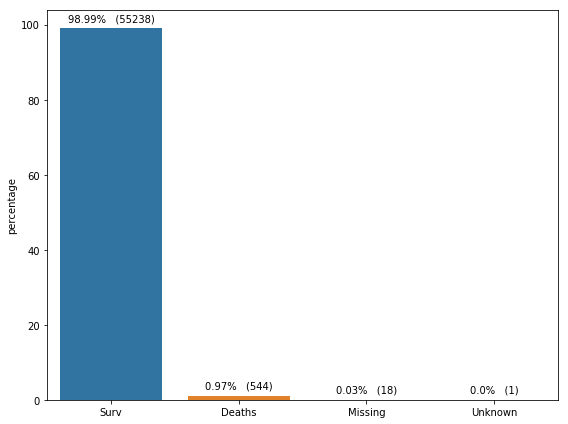

In [9]:
## another way to plot total_d, this time percentage values
## https://stackoverflow.com/questions/65655829/absolute-values-and-percentage-values-side-by-side-in-bar-chart-matplotlib/65725322#65725322
x_axis = total_d.index
# x_axis = ['MJO Active', 'MJO Inactive']
# x_axis
y_axis = total_d['percentage']
# y_axis

fig, ax = plt. subplots(figsize=(8,6))
rects = sns.barplot(x_axis, y_axis, linewidth=0)

values = total_d['count']

for rect, perc, vals in zip(rects.patches, y_axis, values):
    rects.annotate(f"{perc}%   ({vals})", (rect.get_x() + rect.get_width() / 2., rect.get_height()),
                  ha='center', va='center', fontsize=10, color='black', xytext=(0,10),
                  textcoords='offset points')
plt.tight_layout()

### Total Covid Outcomes by Age Group
---
Deaths and Survivals


In [10]:
## totals by age group (tba)
tba = df.groupby(['age_group','death_yn'])['death_yn'].count().unstack().fillna(0)
tba = tba.rename(columns = {'No': 'surv', 'Yes':'deaths'})
tba[['Missing', 'surv', 'Unknown', 'deaths']] = tba[['Missing', 'surv', 'Unknown', 'deaths']].astype(int)

## Add Grand total
tba['total'] = tba[['Missing', 'surv', 'Unknown', 'deaths']].sum(axis=1).astype(int)

## Add % values for missing (miss_p) survival (surv_p),  unknown (unkn_p), deaths (dths_p), total (totl_p)
## percentages by row, within each age group
tba['miss_p'] = ((tba['Missing']*100)/tba['total']).round(1)
tba['surv_p'] = ((tba['surv']*100)/tba['total']).round(1)
tba['unkn_p'] = ((tba['Unknown']*100)/tba['total']).round(1)
tba['dths_p'] = ((tba['deaths']*100)/tba['total']).round(1)
tba['totl_p'] = (tba['total']*100)/tba['total']

tba.reset_index()

death_yn,age_group,Missing,surv,Unknown,deaths,total,miss_p,surv_p,unkn_p,dths_p,totl_p
0,0 - 9 Years,1,2904,0,0,2905,0.0,100.0,0.0,0.0,100.0
1,10 - 19 Years,4,5715,0,0,5719,0.1,99.9,0.0,0.0,100.0
2,20 - 29 Years,8,13493,1,2,13504,0.1,99.9,0.0,0.0,100.0
3,30 - 39 Years,2,10749,0,3,10754,0.0,100.0,0.0,0.0,100.0
4,40 - 49 Years,0,8701,0,22,8723,0.0,99.7,0.0,0.3,100.0
5,50 - 59 Years,1,7015,0,46,7062,0.0,99.3,0.0,0.7,100.0
6,60 - 69 Years,1,3800,0,70,3871,0.0,98.2,0.0,1.8,100.0
7,70 - 79 Years,1,1754,0,145,1900,0.1,92.3,0.0,7.6,100.0
8,80+ Years,0,1091,0,256,1347,0.0,81.0,0.0,19.0,100.0


### Deaths & Survivals Percentage by Age Group


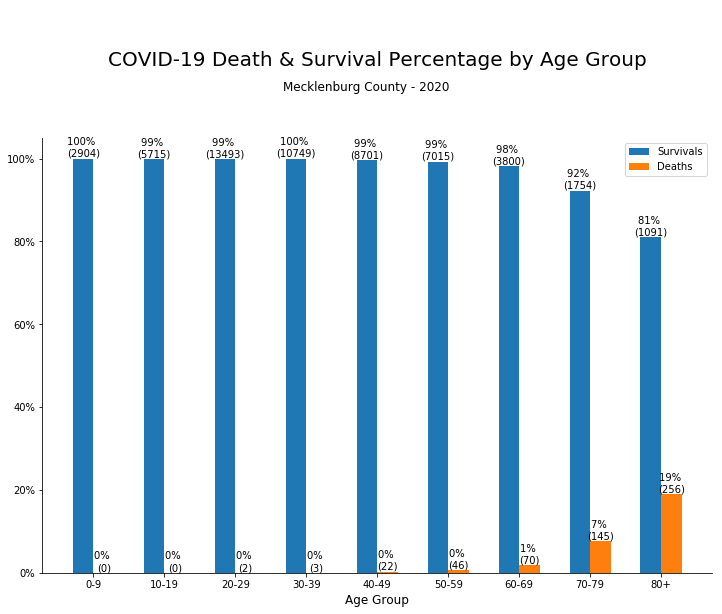

In [11]:
## plotting tba % values by age group
surv_perc = tba['surv_p']
deaths_perc = tba['dths_p']
x_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']


x= np.arange(len(x_labels))
width = 0.29 ##bars width

fig, ax = plt.subplots(figsize=(12,8))

rects1 = ax.bar(x, surv_perc, width, label= 'Survivals')
rects2 = ax.bar(x + width, deaths_perc,width, label='Deaths')

plt.xticks(x + width /2, x_labels);

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('\n\nCOVID-19 Death & Survival Percentage by Age Group\n\n\n', fontsize =20)
fig.suptitle('Mecklenburg County - 2020')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xlabel('Age Group', fontsize=12)
ax.legend(['Survivals', 'Deaths'])

survivors = tba['surv']
deaths = tba['deaths']

def autolabels(rects, qtys):
    for rect, qty in zip(rects, qtys):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2.,1. * height,
               f'{int(height)}% \n({qty})',
                ha='center', va='bottom')
autolabels(rects1, survivors)
autolabels(rects2, deaths)

## Save chart as png file
ax.figure.savefig(IMAGES/'death_surv_pect-by_age.png' )

In [12]:
# tba.head()

Text(0.5, 1.0, 'Death Count by Age Group -Meck (2020)')

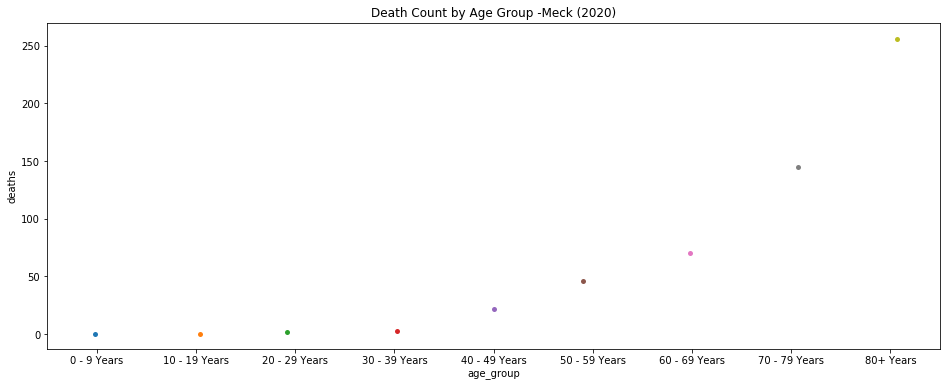

In [13]:
## TO DO ##
## scatter plot death count by age -- maybe different colors for underlying conditions
## check out https://seaborn.pydata.org/generated/seaborn.stripplot.html

ax = plt.subplots(figsize =(16,6))
ax = sns.stripplot(x='age_group', y='deaths', data=tba.reset_index())
ax.set_title('Death Count by Age Group -Meck (2020)')

In [14]:
## plotting 

# ax = tba.reset_index().plot(x='age_group', y=['surv_p', 'dths_p'],
#                 kind='bar',
#                 figsize=(20,9),
#                 rot=0,
#                 fontsize=15)

# for p in ax.patches:
#     width = p.get_width()
#     height = p.get_height()
#     x, y = p.get_xy()
#     ax.annotate(f'{height}%', (x + width/2, y + height*1.02), ha='center')



# ax.set_title('\n\nCOVID-19 Death & Survival Rate by Age Group - 2020\n(Mecklenburg County)\n', fontsize =20)
# ax.yaxis.set_major_formatter(mtick.PercentFormatter())
# ax.set_xticklabels(['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']);
# ax.set_xlabel('Age Group', fontsize=20)
# ax.legend(['Survival Rate', 'Death Rate']);
# ## label group barchart: https://stackoverflow.com/questions/52080991/display-percentage-above-bar-chart-in-matplotlib

# # Hide the right and top spines
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# ## Save chart as png file
# # ax.figure.savefig(IMAGES/'d_s_rate-by_age.png' )

In [15]:
## ***WORK IN PROGRESS***
## another way to plot tba survivals and deaths percentage with labels
## https://stackoverflow.com/questions/65655829/absolute-values-and-percentage-values-side-by-side-in-bar-chart-matplotlib/65725322#65725322

# x_axis = tba['age_group']
# # x_axis = ['MJO Active', 'MJO Inactive']
# # x_axis
# y_axis = tba['surv_p', 'dths_p']

# # fig, ax = plt. subplots(figsize=(20,9))
# # rects = sns.barplot(x_axis, y_axis, linewidth=0)

# ax = tba.plot(x= x_axis, y= y_axis,
#                 kind='bar',
#                 figsize=(20,9),
#                 rot=0,
#                 title= '\n\nDeaths vs Survivals Rate by Age Group\n')


# values = tba['surv', 'deaths']

# for rect, perc, vals in zip(rects.patches, y_axis, values):
#     rects.annotate(f"{perc}% ({vals})", (rect.get_x() + rect.get_width() / 2., rect.get_height()),
#                   ha='center', va='center', fontsize=13, color='black', xytext=(0,10),
#                   textcoords='offset points')

# # for rect, perc, vals in zip(rects.patches, y_axis, values):
# #     rects.annotate(f"{perc}% ({vals})", (rect.get_x() + rect.get_width() / 2., rect.get_height()),
# #                   ha='center', va='center', fontsize=13, color='black', xytext=(0,10),
# #                   textcoords='offset points')
# plt.tight_layout()

In [16]:
## calculating and plotting  monthly Death percentage by age bracket 
# tba[['Missing', 'surv', 'Unknown', 'deaths']].sum().astype(int)

## gettinga of each column
total_counts = pd.DataFrame(tba[['Missing', 'surv', 'Unknown', 'deaths']].sum().astype(int)).T
total_counts

## getting percentages



death_yn,Missing,surv,Unknown,deaths
0,18,55222,1,544


<br><br>

### Deaths by Age Bracket
---


In [17]:
## Filtering rows where 'death_yn' is 'yes'
## did this to plot every single row, and compare it with other columns
deaths_yes = df[(df['death_yn'].str.contains('Yes'))]
# deaths['count'] = 1

# deaths.dtypes
# deaths.death_yn.unique()
deaths_yes.head()

,race_ethnicity_combined,current_status,cdc_case_earliest_dt,cdc_report_dt,sex,onset_dt,pos_spec_dt,hosp_yn,icu_yn,death_yn,hc_work_yn,pna_yn,abxchest_yn,acuterespdistress_yn,mechvent_yn,fever_yn,sfever_yn,chills_yn,myalgia_yn,runnose_yn,sthroat_yn,cough_yn,sob_yn,nauseavomit_yn,headache_yn,abdom_yn,diarrhea_yn,medcond_yn,county_fips_code,res_county,res_state,age_group
5057,"White, Non-Hispanic",Laboratory-confirmed case,2020-04-16,2020-04-16,Female,NaN,2020-04-16,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Missing,Yes,Unknown,Yes,Yes,Missing,Yes,Yes,Yes,No,Yes,Missing,Yes,Yes,37119.0,Mecklenburg,NC,60 - 69 Years
5491,Hispanic/Latino,Laboratory-confirmed case,2020-11-18,2020-11-18,Male,2020-11-18,2020-11-23,Yes,Unknown,Yes,No,Unknown,Unknown,Unknown,Missing,Unknown,Yes,Yes,Unknown,Missing,Unknown,Yes,Unknown,Unknown,Unknown,Missing,Unknown,Unknown,37119.0,Mecklenburg,NC,70 - 79 Years
5499,Hispanic/Latino,Laboratory-confirmed case,2020-11-14,2020-11-14,Male,2020-11-14,2020-11-17,Yes,Unknown,Yes,No,Yes,Unknown,Unknown,Missing,Unknown,Unknown,Unknown,Unknown,Missing,Unknown,Yes,Yes,Unknown,Unknown,Missing,Unknown,Unknown,37119.0,Mecklenburg,NC,70 - 79 Years
5529,"Black, Non-Hispanic",Laboratory-confirmed case,2020-11-03,2020-11-01,Female,2020-11-03,2020-11-01,Yes,Yes,Yes,Missing,Unknown,Unknown,Unknown,Missing,Unknown,Unknown,Unknown,Unknown,Missing,Unknown,Unknown,Yes,Unknown,Unknown,Missing,Unknown,Unknown,37119.0,Mecklenburg,NC,70 - 79 Years
5533,"Black, Non-Hispanic",Laboratory-confirmed case,2020-11-13,2020-11-13,Female,NaN,2020-11-13,Yes,Unknown,Yes,Missing,Unknown,Unknown,Unknown,Missing,Unknown,Unknown,Unknown,Unknown,Missing,Unknown,Unknown,Unknown,Unknown,Unknown,Missing,Unknown,Yes,37119.0,Mecklenburg,NC,70 - 79 Years


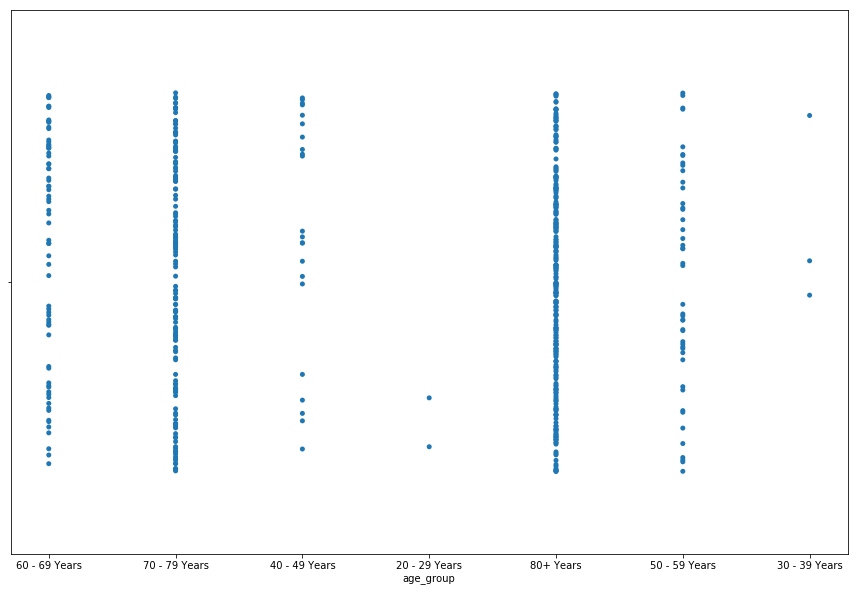

In [18]:
## TO DO ##
## scatter plot death count by age --plot all cases -- maybe different colors for underlying condition
ax = plt.subplots(figsize=(15,10))

## stripplot
ax = sns.stripplot(x='age_group', hue='death_yn', data=deaths_yes, jitter=0.35)
# ax= sns.stripplot(x='death_yn', y='age_group', data=deaths) ## gets error

## countplot https://stackoverflow.com/questions/34251641/how-to-make-a-bar-plot-of-non-numerical-data-in-pandas
# ax = sns.countplot(y='death_yn', hue='age_group', data=deaths)


### Underlying Medical Conditions
---

medcond_yn

In [19]:
med_cond = deaths_yes.groupby(['age_group','medcond_yn'])['medcond_yn'].count().unstack().reset_index().fillna(0) 
med_cond = med_cond.rename(columns={'No': 'no_other', 'Yes': 'other_cond', 'Unknown': 'unknown'})
med_cond['ttl_deaths'] = (med_cond['no_other']+med_cond['unknown']+med_cond['other_cond']).astype(int)
med_cond['no_other'] = med_cond['no_other'].astype(int)
med_cond['unknown'] = med_cond['unknown'].astype(int)
med_cond['other_cond'] = med_cond['other_cond'].astype(int)
med_cond['no_other_p'] = ((med_cond['no_other']*100)/med_cond['ttl_deaths']).round(1)
med_cond['other_cond_p'] = ((med_cond['other_cond']*100)/med_cond['ttl_deaths']).round(1)
med_cond['unknown_p'] = ((med_cond['unknown']*100)/med_cond['ttl_deaths']).round(1)

med_cond

medcond_yn,age_group,no_other,unknown,other_cond,ttl_deaths,no_other_p,other_cond_p,unknown_p
0,20 - 29 Years,0,2,0,2,0.0,0.0,100.0
1,30 - 39 Years,0,0,3,3,0.0,100.0,0.0
2,40 - 49 Years,4,9,9,22,18.2,40.9,40.9
3,50 - 59 Years,1,19,26,46,2.2,56.5,41.3
4,60 - 69 Years,1,29,40,70,1.4,57.1,41.4
5,70 - 79 Years,2,47,96,145,1.4,66.2,32.4
6,80+ Years,11,91,154,256,4.3,60.2,35.5


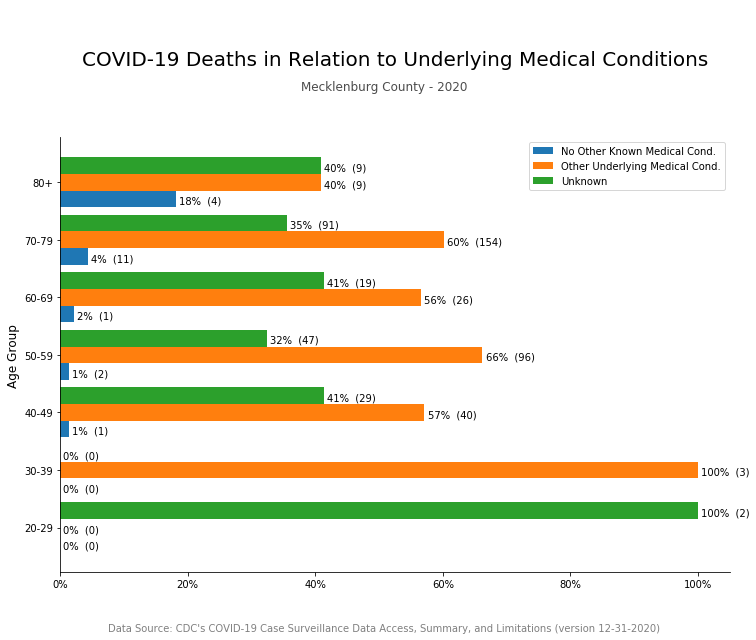

In [20]:
## horizontal barchart med_cond by age group with labels

med_cond_sorted = med_cond.sort_values('no_other_p')
cmaps = 'Purples'
no_other = med_cond_sorted['no_other_p']
other = med_cond_sorted['other_cond_p']
unknown = med_cond_sorted['unknown_p']
y_labels = ['20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']

y = np.arange(len(y_labels))

width = 0.29
fig, ax = plt.subplots(figsize=(12,8))

rects1 = ax.barh(y, no_other, width, label='No Other Medical Cond')
rects2 = ax.barh(y + width, other, width, label='Other Medical Cond')
rects3 = ax.barh(y + width*2, unknown, width, label='unknown')
plt.yticks(y + width, y_labels);

qtys_no = med_cond_sorted['no_other']
qtys_other = med_cond_sorted['other_cond']
qtys_unk = med_cond_sorted['unknown']

# # Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('\n\nCOVID-19 Deaths in Relation to Underlying Medical Conditions\n\n\n', fontsize =20)
fig.suptitle('Mecklenburg County - 2020', color='0.3')
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Age Group', fontsize=12)
ax.legend(['No Other Known Medical Cond.', 'Other Underlying Medical Cond.', 'Unknown']);

text1= fig.text(0.50, 0.02, "Data Source: CDC's COVID-19 Case Surveillance Data Access, Summary, and Limitations (version 12-31-2020)",
               ha='center', va='bottom', wrap=True, color='grey')

def autolabel(rects, qtys):
    for rect, qty in zip(rects, qtys):
        width = rect.get_width()
        ax.text(width + 0.5, rect.get_y() + rect.get_height()/5.,
        f'{int(width)}%  ({qty})', fontsize=10)

autolabel(rects1, qtys_no)
autolabel(rects2, qtys_other)
autolabel(rects3, qtys_unk)
## reference: https://stackoverflow.com/questions/34292076/pandas-bar-plot-how-to-annotate-grouped-horizontal-bar-charts

# plt.tight_layout()


## Save chart as png file
# ax.figure.savefig(IMAGES/'deaths_med_conds.png' )

In [21]:
## Plot med_cond vertical barchart

# ax = med_cond.plot(x='age_group', y=['no_other_p', 'other_cond_p', 'unknown_p'],
#                 kind='bar',
#                 figsize=(20,9),
#                 rot=0,
#                 fontsize=15)

# ## labels on top of bars
# for p in ax.patches:
#     width = p.get_width()
#     height = p.get_height()
#     x, y = p.get_xy()
#     ax.annotate(f'{int(height)}%', (x + width/1.7, y + height*1.02), ha='center')
    
# ax.set_title('\n\nCOVID-19 Deaths That Presented Underlying Medical Conditions - 2020\n(Mecklenburg County)\n', fontsize =20)
# ax.yaxis.set_major_formatter(mtick.PercentFormatter())
# ax.set_xticklabels(['20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']);
# ax.set_xlabel('Age Group', fontsize=20)
# ax.legend(['No Other Known Medical Cond.', 'Other Underlying Medical Cond.', 'Unknown']);

# # # Hide the right and top spines
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)


# ## Save chart as png file
# # ax.figure.savefig(IMAGES/'d_s_rate-by_age.png' )

### Deaths and Underlying Medical Conditions - All Ages
---

In [22]:
## total percentage deaths with other medical conditions - All Ages
total_conds = pd.DataFrame(med_cond[['no_other', 'other_cond', 'unknown']].sum().astype(int)).T
total_conds['total_deaths'] = total_conds['no_other'] + total_conds['other_cond'] + total_conds['unknown']
total_conds['no_other_p'] = ((total_conds['no_other'] * 100) / total_conds['total_deaths']).round(1)
total_conds['other_cond_p'] = ((total_conds['other_cond'] * 100) / total_conds['total_deaths']).round(1)
total_conds['unknown_p'] = ((total_conds['unknown'] * 100) / total_conds['total_deaths']).round(1)
# total_conds.info()
total_conds

medcond_yn,no_other,other_cond,unknown,total_deaths,no_other_p,other_cond_p,unknown_p
0,19,328,197,544,3.5,60.3,36.2


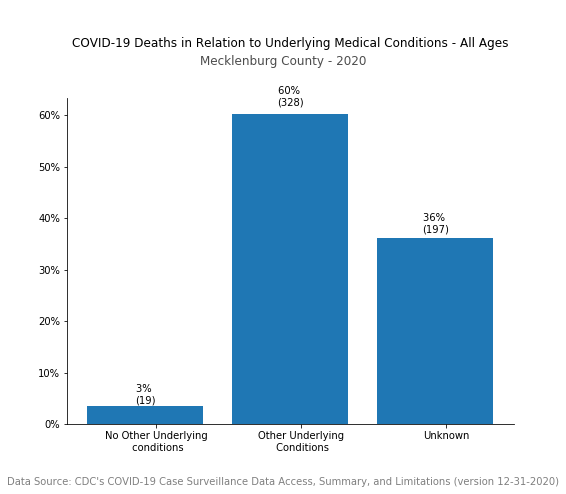

In [23]:
## plotting % of deaths related to LTC

fig, ax = plt.subplots(figsize=(8,6))

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_title('\n\nCOVID-19 Deaths in Relation to Underlying Medical Conditions - All Ages\n\n\n')
fig.suptitle('Mecklenburg County - 2020', color='0.3')

text_bottom = fig.text(0.50, -0.02, "Data Source: CDC's COVID-19 Case Surveillance Data Access, Summary, and Limitations (version 12-31-2020)", 
                      ha='center', va='bottom', wrap=True, color='grey')

ttl_dths = total_conds[['no_other_p', 'other_cond_p', 'unknown_p']].loc[0].tolist()
x_labels = ['No Other Underlying\n conditions', 'Other Underlying\n Conditions', 'Unknown']

x = np.arange(len(x_labels))
width = 0.15

rects = ax.bar(x_labels, ttl_dths)

plt.xticks(x + width / 2, x_labels);

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# # quantity values
ltc_qty = total_conds[['no_other', 'other_cond', 'unknown']].loc[0].tolist()
# ltc_qty

def autolabel(rects, qtys):
    for rect, qty in zip(rects, qtys):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., 1.02 * height,
               f'{int(height)}% \n({qty})',
               ha='center', va='bottom')

autolabel(rects, ltc_qty)

## Save chart as png file
# ax.figure.savefig(IMAGES/'total_deaths_ Underlying_conditions.png', bbox_inches='tight', dpi=200);
## saving figure fix text cutting off and high resolution: https://www.youtube.com/watch?v=C8MT-A7Mvk4

In [24]:
# ax = sns.heatmap(deaths.groupby(['age_group','medcond_yn'])['medcond_yn'].count().unstack(), annot=True, fmt='.4g')